In [1]:
#
# Jupyter python notebook to estimate ARGO Oxygen Correction.
# DOXY_ADJUSTED is corrected via the correction of the partial pressure PPOX as in 'Bittig and al (2018)'
# https://dx.doi.org/10.3389/fmars.2017.00429

#instruction to be able to zoom on matplotlib figure
%matplotlib widget 

# Path to LOCODOX python
import sys
sys.path.insert(0,'/Users/chemon/ARGO_NEW/NEW_LOCODOX/locodox_python/source')

# Import python module
import os
import argopy
import xarray as xr
import glob
import numpy as np
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
import seawater as sw
from datetime import date
import copy

# Import module developped for LOCODOX
from m_argo_data import open_argo_multi_profile_file, get_argo_launch_date, get_argo_optode_height, get_argo_data_for_WOA
from m_argo_data import get_argo_data_for_NCEP
from m_WOA_data import open_WOA_file, interp_WOA_on_ARGO
from m_NCEP_data import open_NCEP_file, interp_NCEP_on_ARGO, calcul_NCEP_PPOX
from m_NCEP_data import download_NCEP_if_needed
from m_users_fonctions import interp_pres_grid,O2stoO2p, O2ctoO2p, O2ptoO2c, O2ctoO2s,umolkg_to_umolL, diff_time_in_days, copy_attr, write_ASCII_file
from m_model_curve_fit import model_Gain, model_Gain_Derive, model_Gain_CarryOver, model_Gain_Derive_CarryOver, model_Gain_pres
from m_users_plot import plot_WMO_position, plot_DOXY_QC, plot_QC_cycle, plot_DOXY_cycle, plot_ppox_Inair_Inwater_Ncep, plot_cmp_corr_NCEP, plot_cmp_corr_WOA
from m_users_plot import plot_cmp_ARGO_CTD, plot_cmp_corr_oxy_woa, plot_Theta_S, plot_CTD_Argo_Pos, plot_cmp_corr_NCEP_with_error, plot_cmp_corr_WOA_with_error
from m_read_write_netcdf import corr_file

/var/folders/vb/_nx050wx16vc32wc3vf7tkrw000h29/T/ipykernel_12834/3321788754.py:24: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [2]:
#####################
# Initialization.
###################

# Results Directory.
# The BD files and the ASCII result file ill be created in this directory.
###################################################
rep_fic_res = '/Users/chemon/ARGO_NEW/NEW_LOCODOX/locodox_python/fic_netcdf_test'
# ASCII file root containing the different corrections estimated
racine_res = 'locodox_res_'

# Relative error to be written in the BD files
percent_relative_error = 2.0


# Which plot ?
###############
# info_plot = 1 : all plots
# info_plot = 0 : not all plots are created.
info_plot = 1 
# Figures Directory
rep_fic_fig = '/Users/chemon/tmp' #'/Users/chemon/ARGO_NEW/rinko_aanderaa/cmp_rinko_aanderaa/figures'

# ARGO Directory : contains 1 subdirectory by float.
# In the Argo float directory, you can find the Rtraj/Sprof/meta Netcdf Files and the 'profiles' subdirectory
# with the BR/BR and R/D files
# WMO Float (string format) to be corrected / Cycles to be used
#################################################################
# Argo directory
#rep_data_argo = '/Volumes/argo/gdac/dac/coriolis/'
rep_data_argo = '/Users/chemon/ARGO_NEW/rinko_aanderaa/cmp_rinko_aanderaa/'
# Argo float
#num_float = '6902882' 
num_float = '6990661'
# Cycle to use to estimate the correction
first_cycle_to_use = 5
last_cycle_to_use = 32

#
# sensor_aanderaa = 1 if aanderaa sensor, 0 if rinko sensor
sensor_aanderaa = 1
if sensor_aanderaa == 1:
    racine_res = racine_res + '_aanderaa_' 
    pcoef2 = 0.00022
    pcoef3 = 0.0419
    rep_data_argo = rep_data_argo + 'doxy_aanderaa'
else:
    racine_res = racine_res + '_rinko_' 
    pcoef2 = 0
    pcoef3 = 0.04
    rep_data_argo = rep_data_argo + 'doxy_rinko'

    
# Complete ASCII file name
fic_res_ASCII = os.path.join(rep_fic_res,racine_res + num_float)


# Which ARGO variables (PRES/PSAL/TEMP) to be used to estimate correction.
#################################################
# which_var = 1 : RAW Data
# which_var = 2 : Adjusted Data
# which_var = 3 : Adjusted Data if available, otherwise Raw Data
which_var = 2
# Which QC used for pressure, temperature, salinity and oxygen.
# In Sprof, we got interpolated data (flag=8)
pres_qc = [1,2,8]
temp_qc = [1,2,8]
sal_qc = [1,2,8]
doxy_qc = [1,2,3,8]
# ARGO InAir code
code_inair = [699,711,799]
# Argo InWater code
code_inwater = [690,710]
# Min and max pressure to extract the salinity for inwater data (because for inwater data, the pump is off.
# So, we decided to take the salinity from the profile (with the pump on).
min_pres = 0
max_pres = 10

# CTD comparison to estimate a supplement gain.
##################################################
# cmp_ctd = 1 : we used CTD, 0 otherwise
cmp_ctd = 1
# rep_ctd : CTD directory
#rep_ctd = ['/Volumes/lpo5/HYDROCEAN/MLT_NC/LPO/OVIDE/']
# fic_ctd : Netcdf file containing STATION_NUMBER, PRES, PSAL, TEMP
#fic_ctd = ['ovid18_PRES.nc'] 
# num_cycle : cycle to be compared with CTD. You can compare many cycles with many CTD.
#num_cycle = np.array([3]) 
# num_ctd : CTD to be compared with cycle. 
# num_cycle[I] is compared with num_ctd[I].
#num_ctd = np.array([105]) 


rep_ctd = ['/Volumes/lops/users/clebihan/2024_CROSSROAD/ajustage_data/5_final_data/mlt/']
# fic_ctd : Netcdf file containing STATION_NUMBER, PRES, PSAL, TEMP
fic_ctd = ['cr24d_PRES.nc'] 
# num_cycle : cycle to be compared with CTD. You can compare many cycles with many CTD.
num_cycle = np.array([5]) #np.array([5]) 
# num_ctd : CTD to be compared with cycle. 
# num_cycle[I] is compared with num_ctd[I].
num_ctd = np.array([6])  #np.array([7]) 

# Pressure effect 
###################
# Pressure for pressure effect estimation. We use pressure > pressure_threshold
pressure_threshold = 1000  

# Bathymetry plot
# Bathymetry file
fic_bathy = '/Users/chemon/ARGO_NEW/LOCODOX/DATA/LOCODOX_EXTERNAL_DATA/TOPOGRAPHY/ETOPO2v2c_f4.nc'
#  Dataset associated
ds_bathy = xr.open_dataset(fic_bathy)
# extension for Position plot
extend_lon_lat = 0.5
# Depth for bathymetry contouring
depths = np.arange(-7000,500,500)

# WOA correction
##################
# fic_woa : WOA file
# Tis file contains the WOA variables (doxywoa,Psatwoa/density/preswoa/PSAL_WOA/TEMP_WOA).
# Ex : doxywoa(time,Depth,lat,lon) with time=12,lat=180,lon=360,Depth=102 : contains the monthly average of doxy
# This file is created by an internal LOPS routine. It can change.
#
# WOA file
fic_WOA = '/Users/chemon/ARGO_NEW/LOCODOX/DATA/LOCODOX_EXTERNAL_DATA/WOA/WOA2018_DECAV_monthly_5500_1deg.nc'
# Min and max pressure used to estimate WOA correction. 
min_pres_interp = 0
max_pres_interp = 25

# NCEP Correction
######################
# NCEP directory : where the NCEP slp/air.sig995/rhum.sig995 can be found or downloaded if needed
rep_NCEP_data= '/Users/chemon/ARGO_NEW/NEW_LOCODOX/NCEP_DATA/'
# NCEP ftp server
ftp_server = 'ftp.cdc.noaa.gov'
# Ncep ftp directory
rep_ftp = 'Datasets/ncep.reanalysis/surface'
# NCEP variables needed.
ncep_variables = ['slp','air.sig995','rhum.sig995']

In [3]:
# Read ARGO files 
ds_argo_meta = open_argo_multi_profile_file(num_float,rep_data_argo,'meta')
ds_argo_Sprof = open_argo_multi_profile_file(num_float,rep_data_argo,'Sprof')
ds_argo_Rtraj = open_argo_multi_profile_file(num_float,rep_data_argo,'Rtraj')

/Users/chemon/ARGO_NEW/rinko_aanderaa/cmp_rinko_aanderaa/doxy_aanderaa/6990661/6990661_meta.nc
/Users/chemon/ARGO_NEW/rinko_aanderaa/cmp_rinko_aanderaa/doxy_aanderaa/6990661/6990661_Sprof.nc
/Users/chemon/ARGO_NEW/rinko_aanderaa/cmp_rinko_aanderaa/doxy_aanderaa/6990661/6990661_Rtraj.nc


In [4]:
# Select the cycles to be used
ds_argo_Sprof = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']>=first_cycle_to_use) & (ds_argo_Sprof['CYCLE_NUMBER']<=last_cycle_to_use),drop=True)
ds_argo_Rtraj = ds_argo_Rtraj.where( (ds_argo_Rtraj['CYCLE_NUMBER']>=first_cycle_to_use) & (ds_argo_Rtraj['CYCLE_NUMBER']<=last_cycle_to_use),drop=True)
ds_argo_Sprof['PLATFORM_NUMBER'] = ds_argo_Sprof['PLATFORM_NUMBER'].astype(int) # The where transform the nan from int to float ...

In [5]:
# Chech ds_argo_Sprof
ds_argo_Sprof

<xarray.Dataset> Size: 3MB
Dimensions:                       (N_PROF: 28, N_PARAM: 5, N_CALIB: 1,
                                   N_LEVELS: 693)
Dimensions without coordinates: N_PROF, N_PARAM, N_CALIB, N_LEVELS
Data variables: (12/65)
    DATA_TYPE                     (N_PROF) object 224B 'Argo synthetic profil...
    FORMAT_VERSION                (N_PROF) object 224B '1.0 ' '1.0 ' ... '1.0 '
    HANDBOOK_VERSION              (N_PROF) object 224B '1.2 ' '1.2 ' ... '1.2 '
    REFERENCE_DATE_TIME           (N_PROF) datetime64[ns] 224B 1950-01-01 ......
    DATE_CREATION                 (N_PROF) datetime64[ns] 224B 2025-05-22T10:...
    DATE_UPDATE                   (N_PROF) datetime64[ns] 224B 2025-05-22T10:...
    ...                            ...
    DOXY2                         (N_PROF, N_LEVELS) float32 78kB 197.0 ... nan
    DOXY2_QC                      (N_PROF, N_LEVELS) float64 155kB 3.0 ... 0.0
    DOXY2_dPRES                   (N_PROF, N_LEVELS) float32 78kB 0.0 ... nan
    DOXY2_ADJUSTED                (N_PROF, N_LEVELS) float32 78kB nan ... nan
    DOXY2_ADJUSTED_QC             (N_PROF, N_LEVELS) float64 155kB 0.0 ... 0.0
    DOXY2_ADJUSTED_ERROR          (N_PROF, N_LEVELS) float32 78kB nan ... nan
Attributes:
    title:                Argo float vertical profile
    institution:          CORIOLIS
    source:               Argo float
    history:              2025-05-22T10:40:13Z creation (software version 1.1...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  1.0
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile
    software_version:     1.18 (version 11.01.2024 for ARGO_simplified_profile)
    id:                   https://doi.org/10.17882/42182

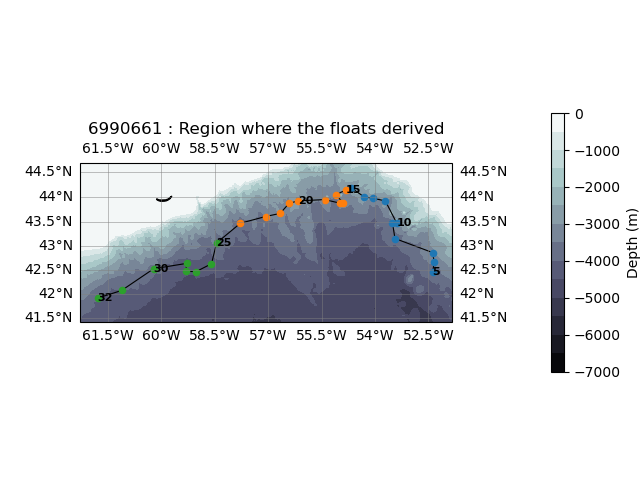

In [6]:
# Maps plotting
if info_plot==1:
    ds_bathy = xr.open_dataset(fic_bathy)
    extend_lon_lat = 0.5
    depths = np.arange(-7000,500,500)
    plot_WMO_position(ds_argo_Sprof, ds_bathy, depths,extend_lon_lat)
    plt.savefig(os.path.join(rep_fic_fig,num_float +'_pos.png'))

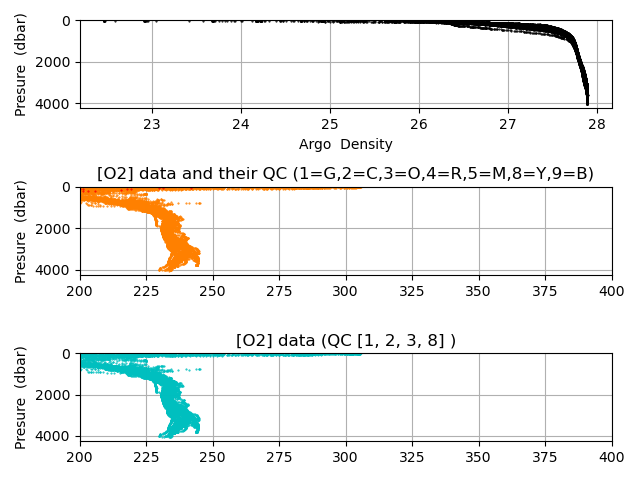

In [7]:
# DOXY_QC plot with PRES/PSAL/TEMP
if info_plot==1:
    plot_DOXY_QC(ds_argo_Sprof,doxy_qc)
    plt.savefig(os.path.join(rep_fic_fig,num_float +'_doxy_qc.png'))

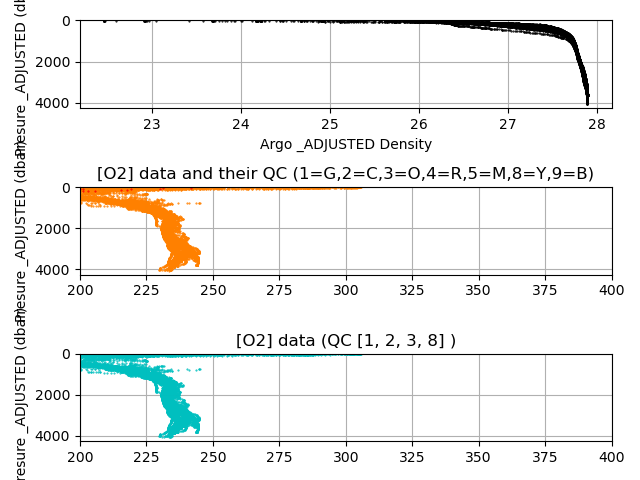

In [8]:
# Same with DATA ADJUSTED (PRES,PSAL,TEMP)
if info_plot==1:
    plot_DOXY_QC(ds_argo_Sprof,doxy_qc,'_ADJUSTED')
    plt.savefig(os.path.join(rep_fic_fig,num_float +'_doxy_qc_PTS_adjusted.png'))

PRES
TEMP
PSAL


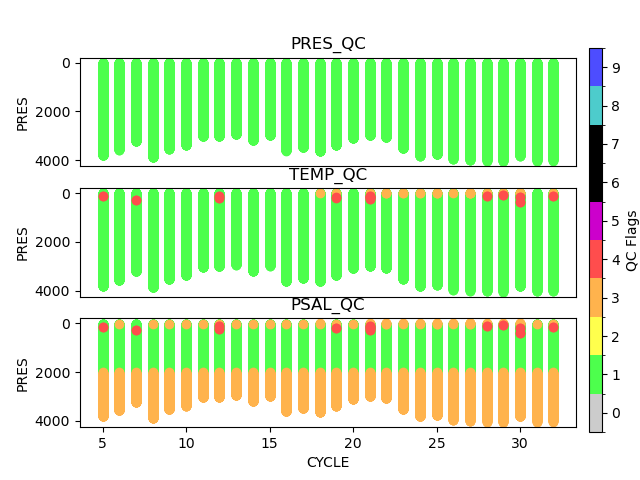

In [9]:
# PRES/PSAL/TEMP QC
if info_plot==1:
    plot_QC_cycle(ds_argo_Sprof)
    plt.savefig(os.path.join(rep_fic_fig,num_float +'_PTS_QC.png'))

PRES_ADJUSTED
TEMP_ADJUSTED
PSAL_ADJUSTED


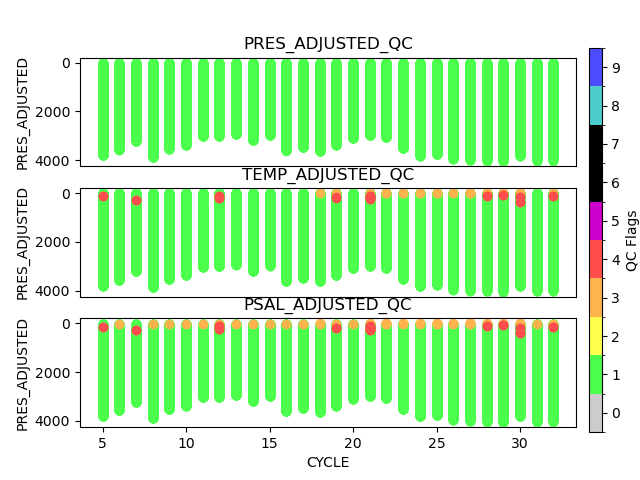

In [10]:
# Same with adjusted DATA
if info_plot==1:
    plot_QC_cycle(ds_argo_Sprof,'_ADJUSTED')
    plt.savefig(os.path.join(rep_fic_fig,num_float +'_PTS_Adjusted_QC.png'))

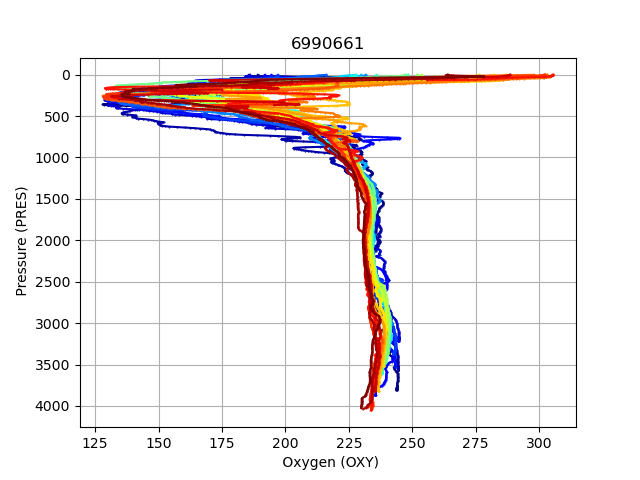

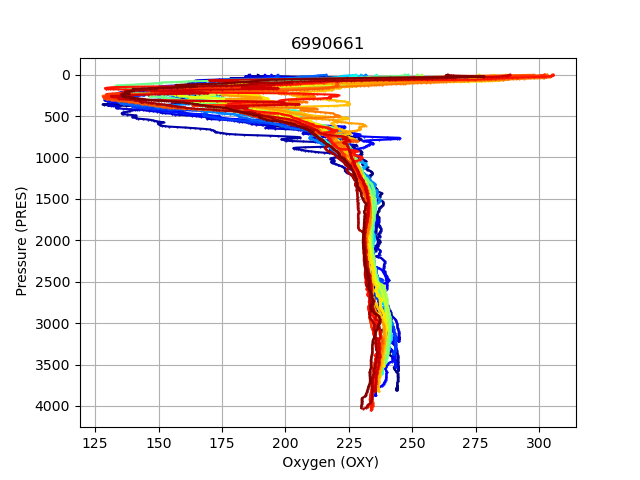

In [11]:
# DOXY RAW DATA
_=plot_DOXY_cycle(ds_argo_Sprof,qc_keep=[1,2,3,8])
plt.savefig(os.path.join(rep_fic_fig,num_float +'_doxy_cycle.png'))
_=plot_DOXY_cycle(ds_argo_Sprof)


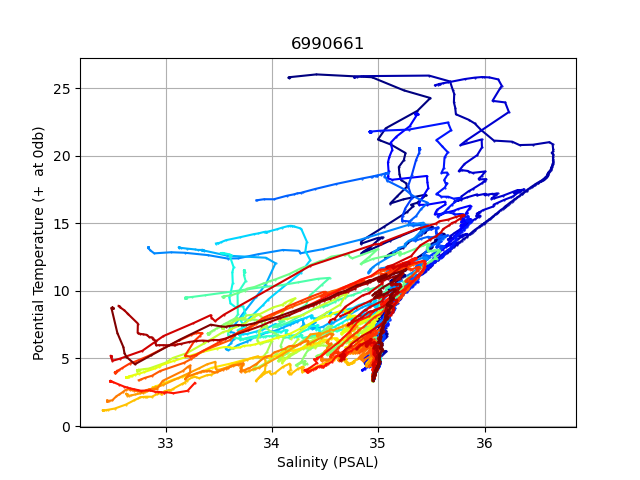

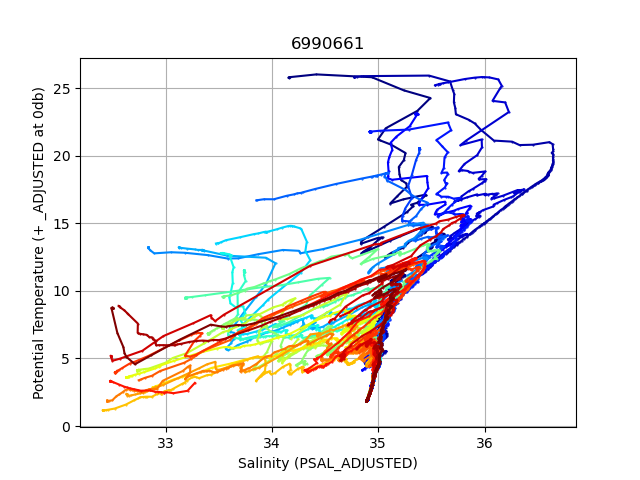

In [12]:
# Theta/S
#_=plot_Theta_S(ds_argo_Sprof)
#_=plot_Theta_S(ds_argo_Sprof,'_ADJUSTED')
_=plot_Theta_S(ds_argo_Sprof,qc_keep=[1,2,8])
plt.savefig(os.path.join(rep_fic_fig,num_float +'_theta_S.png'))
_=plot_Theta_S(ds_argo_Sprof,'_ADJUSTED',qc_keep=[1,2,8])
plt.savefig(os.path.join(rep_fic_fig,num_float +'_theta_S_adjusted.png'))



In [13]:
# Launch data
launch_date = get_argo_launch_date(ds_argo_meta)
print(launch_date)
optode_height = get_argo_optode_height(ds_argo_meta)
print(optode_height)

2024-08-03T22:21:00.000000000
-0.3


In [14]:
# Delta time from launch date
delta_T_sprof = diff_time_in_days(ds_argo_Sprof['JULD'],launch_date)
delta_T_sprof

<xarray.DataArray 'JULD' (N_PROF: 28)> Size: 224B
array([ 21.11111111,  30.99097222,  40.85138889,  51.14791667,
        60.97638889,  70.91388889,  80.78541667,  90.77777778,
       100.75694444, 110.84791667, 120.78055556, 131.02986111,
       140.98472222, 151.02708333, 160.93888889, 170.82916667,
       180.78402778, 190.80486111, 200.97222222, 211.11319444,
       221.09722222, 231.36666667, 241.36736111, 251.36458333,
       261.37152778, 271.11736111, 281.37152778, 291.39722222])
Dimensions without coordinates: N_PROF

In [15]:
################################## 
# Correction estimated with WOA
##################################
# ARGO data needed for WOA correction.
# ds_argo contains variables needed to estimate correction with WOA.
ds_argo = get_argo_data_for_WOA(ds_argo_Sprof,pres_qc,temp_qc,sal_qc,doxy_qc,which_var)
ds_argo

PSAL ADJUSTED Data Used
PRES ADJUSTED Data Used
TEMP ADJUSTED Data Used


<xarray.Dataset> Size: 932kB
Dimensions:       (N_PROF: 28, N_LEVELS: 693)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables:
    TEMP_ARGO     (N_PROF, N_LEVELS) float32 78kB 25.77 25.79 25.8 ... nan nan
    TEMP_ARGO_QC  (N_PROF, N_LEVELS) float64 155kB 1.0 1.0 1.0 ... 0.0 0.0 0.0
    PSAL_ARGO     (N_PROF, N_LEVELS) float32 78kB 34.16 34.16 34.16 ... nan nan
    PSAL_ARGO_QC  (N_PROF, N_LEVELS) float64 155kB 1.0 1.0 1.0 ... 0.0 0.0 0.0
    DOXY_ARGO     (N_PROF, N_LEVELS) float32 78kB 189.1 189.2 189.2 ... nan nan
    DOXY_ARGO_QC  (N_PROF, N_LEVELS) float64 155kB 3.0 3.0 3.0 ... 0.0 0.0 0.0
    PRES_ARGO     (N_PROF, N_LEVELS) float32 78kB 3.4 4.8 7.1 ... nan nan nan
    PRES_ARGO_QC  (N_PROF, N_LEVELS) float64 155kB 1.0 1.0 1.0 ... 0.0 0.0 0.0
    JULD          (N_PROF) datetime64[ns] 224B 2024-08-25T01:00:59.999999488 ...
    LONGITUDE     (N_PROF) float64 224B -52.38 -52.34 -52.38 ... -61.11 -61.78
    LATITUDE      (N_PROF) float64 224B 42.46 42.67 42.86 ... 42.53 42.08 41.92
    CYCLE_NUMBER  (N_PROF) float64 224B 5.0 6.0 7.0 8.0 ... 29.0 30.0 31.0 32.0
Attributes:
    title:                Argo float vertical profile
    institution:          CORIOLIS
    source:               Argo float
    history:              2025-05-22T10:40:13Z creation (software version 1.1...
    references:           http://www.argodatamgt.org/Documentation
    user_manual_version:  1.0
    Conventions:          Argo-3.1 CF-1.6
    featureType:          trajectoryProfile
    software_version:     1.18 (version 11.01.2024 for ARGO_simplified_profile)
    id:                   https://doi.org/10.17882/42182

In [16]:
# Delta Times from launch_date
delta_T_WOA = diff_time_in_days(ds_argo['JULD'].values,launch_date)

In [17]:
# WOA file reading
ds_woa = open_WOA_file(fic_WOA)
ds_woa

We force Longitude in [-180 180]


<xarray.Dataset> Size: 4GB
Dimensions:    (lat: 180, lon: 360, N_LEVELS: 102, time: 12)
Coordinates:
  * Depth      (N_LEVELS) float64 816B 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time       (time) float64 96B 15.0 46.0 75.0 106.0 ... 289.0 320.0 350.0
Dimensions without coordinates: lat, lon, N_LEVELS
Data variables:
    latitude   (lat) float64 1kB ...
    longitude  (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... -3.5 -2.5 -1.5 -0.5
    doxywoa    (time, N_LEVELS, lat, lon) float64 635MB ...
    Psatwoa    (time, N_LEVELS, lat, lon) float64 635MB ...
    density    (time, N_LEVELS, lat, lon) float64 635MB ...
    preswoa    (time, N_LEVELS, lat, lon) float64 635MB ...
    PSAL_WOA   (time, N_LEVELS, lat, lon) float64 635MB ...
    TEMP_WOA   (time, N_LEVELS, lat, lon) float64 635MB ...

In [18]:
# Interp WOA data on ARGO time
ds_woa_interp_on_ARGO = interp_WOA_on_ARGO(ds_woa, ds_argo)

WOA time Extrapolation for interpolation

<xarray.Dataset> Size: 4GB
Dimensions:   (lat: 180, lon: 360, N_LEVELS: 102, time: 14)
Coordinates:
  * lat       (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... -4.5 -3.5 -2.5 -1.5 -0.5
  * Depth     (N_LEVELS) float64 816B 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time      (time) float64 112B -15.25 15.0 46.0 75.0 ... 320.0 350.0 380.2
Dimensions without coordinates: N_LEVELS
Data variables:
    doxywoa   (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    Psatwoa   (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    density   (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    preswoa   (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    PSAL_WOA  (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
    TEMP_WOA  (N_LEVELS, lat, lon, time) float64 740MB nan nan nan ... nan nan
101.86589

In [19]:
# Interpolation WOA et ARGO on regular grid (defined at the beginning)
print(f"WOA/ARGO Interpolation between {min_pres_interp} et {max_pres_interp}")
var_to_interpol = [var for var in ds_woa_interp_on_ARGO.data_vars if "N_LEVELS" in ds_woa_interp_on_ARGO[var].dims]
ds_woa_interp = interp_pres_grid(min_pres_interp,max_pres_interp,var_to_interpol,ds_woa_interp_on_ARGO,'preswoa','Depth')

var_to_interpol = [var for var in ds_argo.data_vars if "N_LEVELS" in ds_argo[var].dims]
ds_argo_interp = interp_pres_grid(min_pres_interp,max_pres_interp,var_to_interpol,ds_argo,'PRES_ARGO','N_LEVELS')

WOA/ARGO Interpolation between 0 et 25
Interpolation variable doxywoa on a regular pressure grid
Interpolation variable Psatwoa on a regular pressure grid
Interpolation variable density on a regular pressure grid
Interpolation variable preswoa on a regular pressure grid
Interpolation variable PSAL_WOA on a regular pressure grid
Interpolation variable TEMP_WOA on a regular pressure grid
Interpolation variable TEMP_ARGO on a regular pressure grid
Interpolation variable TEMP_ARGO_QC on a regular pressure grid
Interpolation variable PSAL_ARGO on a regular pressure grid
Interpolation variable PSAL_ARGO_QC on a regular pressure grid
Interpolation variable DOXY_ARGO on a regular pressure grid
Interpolation variable DOXY_ARGO_QC on a regular pressure grid
Interpolation variable PRES_ARGO on a regular pressure grid
Interpolation variable PRES_ARGO_QC on a regular pressure grid


In [20]:
# Add attributes in data interp 
ds_argo_interp = copy_attr(ds_argo,ds_argo_interp)
ds_woa_interp = copy_attr(ds_woa_interp_on_ARGO,ds_woa_interp)

In [21]:
# PPOX WOA.
ppox_WOA = O2stoO2p(ds_woa_interp['Psatwoa'],ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO']) 
ppox_WOA_mean = np.nanmean(ppox_WOA,axis=1)

In [22]:
# PPOX ARGO
ana_dens = sw.pden(ds_argo_interp['PSAL_ARGO'],ds_argo_interp['TEMP_ARGO'],np.arange(min_pres_interp,max_pres_interp+1,1),0)
O2_ARGO_umolL = umolkg_to_umolL(ds_argo_interp['DOXY_ARGO'],ds_argo['DOXY_ARGO'].units,ana_dens)

ppox_ARGO = O2ctoO2p(O2_ARGO_umolL,ds_argo_interp['TEMP_ARGO'],ds_argo_interp['PSAL_ARGO']) # On calcule PPOX pour P=0
ppox_ARGO_mean = np.nanmean(ppox_ARGO,axis=1)

In [23]:
# Correction WOA : Gain estimation
initial_guess = 1  # Valeurs initiales pour G 
params_Gain_WOA, covariance = curve_fit(model_Gain, ppox_ARGO_mean/ppox_ARGO_mean, ppox_WOA_mean/ppox_ARGO_mean, p0=initial_guess,nan_policy='omit')
perr_Gain_WOA = np.sqrt(np.diag(covariance))
print(f"WOA Gain estimated : {params_Gain_WOA} with an error {perr_Gain_WOA}")


WOA Gain estimated : [1.14493202] with an error [0.00437128]


In [24]:
# Correction WOA : Gain and Drift Time estimation
initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_WOA, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [ppox_ARGO_mean/ppox_ARGO_mean,delta_T_WOA], ppox_WOA_mean/ppox_ARGO_mean, p0=initial_guess,nan_policy='omit',full_output=True)
perr_Gain_Derive_WOA = np.sqrt(np.diag(covariance))
print(f"WOA Gain/Drift estimated : {params_Gain_Derive_WOA} with an error {perr_Gain_Derive_WOA}")


WOA Gain/Drift estimated : [ 1.17003632 -5.01914578] with an error [0.00792987 1.37735028]


In [25]:
######################
# NCEP Correction
#######################
# Download NCEP Data
download_NCEP_if_needed(ds_argo_Sprof['JULD'],ftp_server,rep_ftp,rep_NCEP_data,ncep_variables)

File slp.2024.nc already exists with the same size. No Download
File air.sig995.2024.nc already exists with the same size. No Download
File rhum.sig995.2024.nc already exists with the same size. No Download
File slp.2025.nc already exists with the same size. No Download
File air.sig995.2025.nc already exists with the same size. No Download
File rhum.sig995.2025.nc already exists with the same size. No Download


We look for PSAL in Sprof near the surface between 0 and 10
We look for PSAL_ADJUSTED in Sprof near the surface between 0 and 10


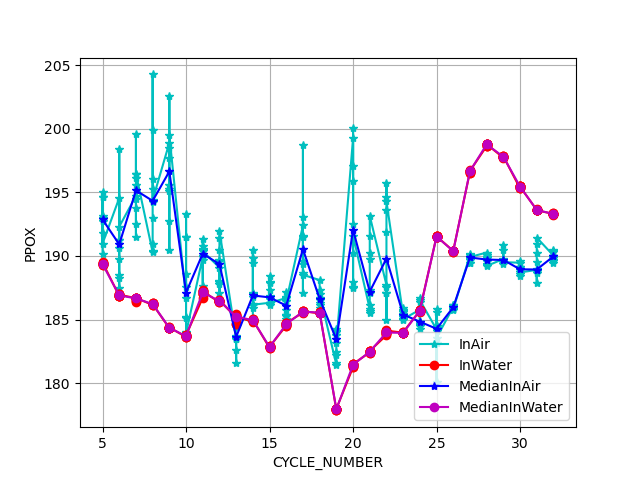

PSAL_ADJUSTED Data is used


In [26]:
# Get ARGO PPOX inair/inwater for NCEP correction
dsair,dsinwater = get_argo_data_for_NCEP(ds_argo_Rtraj,ds_argo_Sprof,which_var,code_inair,code_inwater,min_pres,max_pres)
plt.savefig(os.path.join(rep_fic_fig,num_float +'_InAir_InWater.png'))

In [27]:
dsinwater['CYCLE_NUMBER']

<xarray.DataArray 'CYCLE_NUMBER' (CYCLE_NUMBER: 28)> Size: 224B
array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18.,
       19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30., 31., 32.])
Coordinates:
  * CYCLE_NUMBER  (CYCLE_NUMBER) float64 224B 5.0 6.0 7.0 8.0 ... 30.0 31.0 32.0
Attributes:
    long_name:    Float cycle number of the measurement
    conventions:  0...N, 0 : launch cycle, 1 : first complete cycle
    casted:       1

In [28]:
# Compute NCEP data at ARGO time
ds_NCEP_air,ds_NCEP_rhum, ds_NCEP_slp = open_NCEP_file(rep_NCEP_data)
ds_NCEP_air,ds_NCEP_rhum,ds_NCEP_slp = interp_NCEP_on_ARGO(ds_NCEP_air,ds_NCEP_rhum,ds_NCEP_slp,dsair['LONGITUDE_ARGO'],dsair['LATITUDE_ARGO'],dsair['JULD'])
z0q = 1e-4
NCEP_PPOX = calcul_NCEP_PPOX(dsinwater,ds_NCEP_air,ds_NCEP_rhum,ds_NCEP_slp,optode_height,z0q)

In [29]:
delta_T_NCEP = diff_time_in_days(dsair['JULD'].values,launch_date)
delta_T_NCEP

array([ 21.12853009,  31.00877315,  40.86857639,  51.16527778,
        60.99372685,  70.93107639,  80.80310185,  90.79530093,
       100.7741088 , 110.86555556, 120.79805556, 131.04701389,
       141.00197917, 151.04436343, 160.95652778, 170.84695602,
       180.80133102, 190.82259259, 200.98943287, 211.13094907,
       221.114375  , 231.38430556, 241.38475694, 251.38181713,
       261.38924769, 271.13493056, 281.38923611, 291.41478009])

In [30]:
# Estimate Gain correction with NCEP 
# without CarryOver
PPOX1 = dsair['PPOX_DOXY'].values
PPOX2 = dsinwater['PPOX_DOXY'].values
initial_guess = 1
# Gain
params_Gain_NCEP, covariance,info,mesg,ier = curve_fit(model_Gain, PPOX1/PPOX1, NCEP_PPOX/PPOX1, p0=initial_guess,nan_policy='omit',full_output=True)
perr_Gain_NCEP = np.sqrt(np.diag(covariance))
print(f"NCEP Gain estimated : {params_Gain_NCEP} with an error {perr_Gain_NCEP}")

# with CarryOver
initial_guess = [1, 0]  # Valeurs initiales pour G et C
params_Gain_NCEP_CarryOver, covariance = curve_fit(model_Gain_CarryOver, [PPOX1,PPOX2], NCEP_PPOX, p0=initial_guess,nan_policy='omit')
perr_Gain_NCEP_CarryOver = np.sqrt(np.diag(covariance))
print(f"NCEP Gain/CarryOver estimated : {params_Gain_NCEP_CarryOver} with an error {perr_Gain_NCEP_CarryOver}")


NCEP Gain estimated : [1.11346804] with an error [0.00363353]
NCEP Gain/CarryOver estimated : [ 1.11399776e+00 -1.19341710e-07] with an error [0.00381991 0.05340978]


In [31]:
# Estimate Gain/Drift correction with NCEP 
# without CarryOver
initial_guess = [1, 0]  # G/C
params_Gain_Derive_NCEP, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [PPOX1/PPOX1,delta_T_NCEP], NCEP_PPOX/PPOX1, p0=initial_guess,nan_policy='omit',full_output=True)
perr_Gain_Derive_NCEP = np.sqrt(np.diag(covariance))
print(f"Gain/Drift estimated : {params_Gain_Derive_NCEP} with an error {perr_Gain_Derive_NCEP}")

# with CarryOver
initial_guess = [1, 0, 0]  # G/C/D
params_Gain_Derive_NCEP_CarryOver, covariance = curve_fit(model_Gain_Derive_CarryOver, [PPOX1,PPOX2,delta_T_NCEP], NCEP_PPOX, p0=initial_guess,nan_policy='omit')
perr_Gain_Derive_NCEP_CarryOver = np.sqrt(np.diag(covariance))
print(f"Gain/CarryOver/Drift estimated : {params_Gain_Derive_NCEP_CarryOver} with an error {perr_Gain_Derive_NCEP_CarryOver}")


Gain/Drift estimated : [1.09130682 4.74984355] with an error [0.00638307 1.23927459]
Gain/CarryOver/Drift estimated : [1.09449687e+00 3.12050793e-07 4.06288910e+00] with an error [0.00860351 0.08994358 1.47309372]


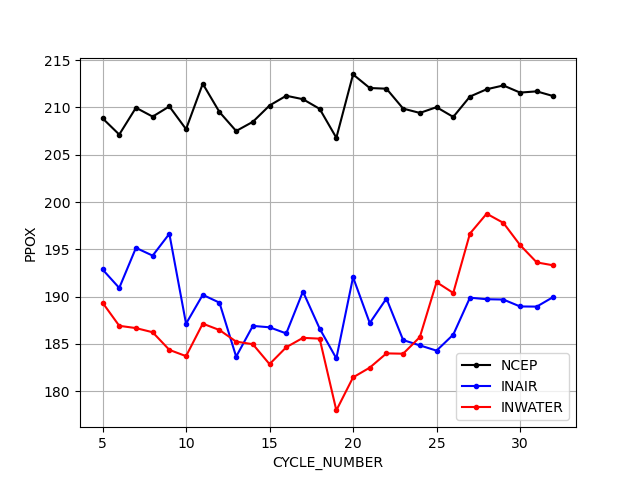

In [32]:
# Plot NCEP and ARGO PPOX
_ = plot_ppox_Inair_Inwater_Ncep(dsair,dsinwater,NCEP_PPOX)
plt.savefig(os.path.join(rep_fic_fig,num_float +'_NCEP_InAir_InWater.png'))

In [33]:
print(params_Gain_NCEP)
print(params_Gain_NCEP_CarryOver)
print(params_Gain_Derive_NCEP)
print(params_Gain_Derive_NCEP_CarryOver)

[1.11346804]
[ 1.11399776e+00 -1.19341710e-07]
[1.09130682 4.74984355]
[1.09449687e+00 3.12050793e-07 4.06288910e+00]


In [34]:
# We don't need the CarryOver value.
params_Gain_NCEP_CarryOver = np.array([params_Gain_NCEP_CarryOver[0]])
params_Gain_Derive_NCEP_CarryOver = np.array(params_Gain_Derive_NCEP_CarryOver[[0,2]])

In [35]:
print(f"Gain Estimation with WOA : {params_Gain_WOA[0]:.4f} with an error {perr_Gain_WOA[0]:.4f}")
print(f"Gain/Drift Estimation with WOA : {params_Gain_Derive_WOA[0]:.4f} / {params_Gain_Derive_WOA[1]:.4f} with an error {perr_Gain_Derive_WOA[0]:.4f} / {perr_Gain_Derive_WOA[1]:.4f}")
print(f"Gain Estimation with NCEP : {params_Gain_NCEP[0]:.4f} with an error {perr_Gain_NCEP[0]:.4f}")
print(f"Gain Estimation with NCEP with CarryOver : {params_Gain_NCEP_CarryOver[0]:.4f} with an error {perr_Gain_NCEP_CarryOver[0]:.4f}")
print(f"Gain/Drift Estimation with NCEP : {params_Gain_Derive_NCEP[0]:.4f} / {params_Gain_Derive_NCEP[1]:.4f} with an error {perr_Gain_Derive_NCEP[0]:.4f} / {perr_Gain_Derive_NCEP[1]:.4f}")
print(f"Gain/Drift Estimation with NCEP with CarryOver : {params_Gain_Derive_NCEP_CarryOver[0]:.4f} / {params_Gain_Derive_NCEP_CarryOver[1]:.4f} with an error {perr_Gain_Derive_NCEP_CarryOver[0]:.4f} / {perr_Gain_Derive_NCEP_CarryOver[2]:.4f}")

Gain Estimation with WOA : 1.1449 with an error 0.0044
Gain/Drift Estimation with WOA : 1.1700 / -5.0191 with an error 0.0079 / 1.3774
Gain Estimation with NCEP : 1.1135 with an error 0.0036
Gain Estimation with NCEP with CarryOver : 1.1140 with an error 0.0038
Gain/Drift Estimation with NCEP : 1.0913 / 4.7498 with an error 0.0064 / 1.2393
Gain/Drift Estimation with NCEP with CarryOver : 1.0945 / 4.0629 with an error 0.0086 / 1.4731


GAIN WOA
Number of pieces : 1
[1.14493202]
Gain NCEP
Number of pieces : 1
[1.11346804]
Gain/Derive WOA
Number of pieces : 1
[ 1.17003632 -5.01914578]
Gain/Derive Ncep
Number of pieces : 1
[1.09130682 4.74984355]
Gain Ncep CarryOver
Number of pieces : 1
[1.11399776]
Gain/Derive Ncep CarryOver
Number of pieces : 1
[1.09449687 4.0628891 ]
GAIN WOA
Number of pieces : 1
[1.14493202]
Gain NCEP
Number of pieces : 1
[1.11346804]
Gain/Derive WOA
Number of pieces : 1
[ 1.17003632 -5.01914578]
Gain/Derive Ncep
Number of pieces : 1
[1.09130682 4.74984355]
Gain Ncep CarryOver
Number of pieces : 1
[1.11399776]
Gain/Derive Ncep CarryOver
Number of pieces : 1
[1.09449687 4.0628891 ]


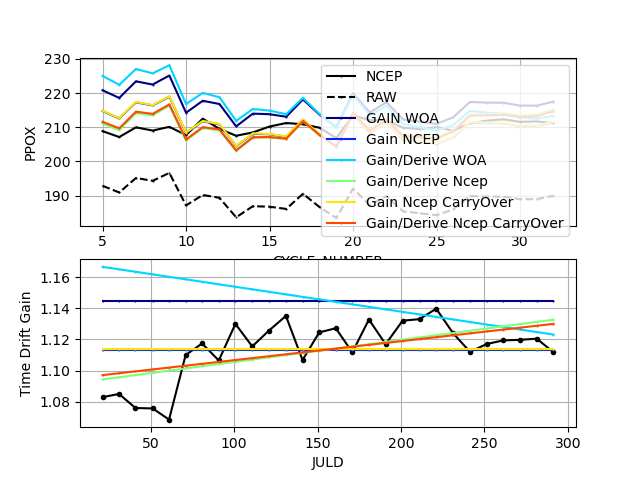

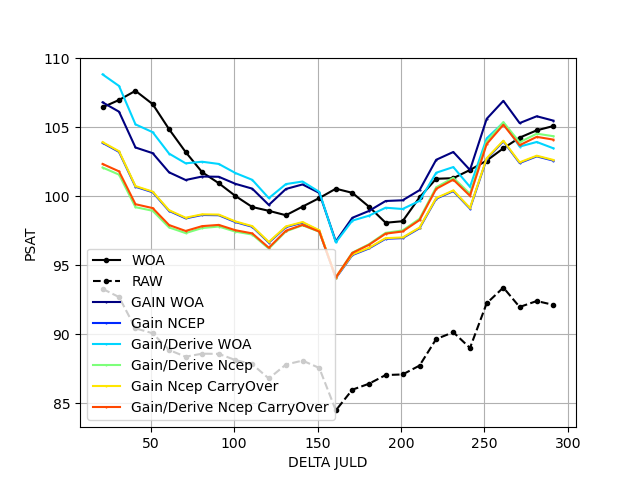

In [36]:
# Compare corrections
# User can change dict_corr.
# Example : dict_corr = {'GAIN WOA' : params_Gain_WOA,'Gain NCEP' : params_Gain_NCEP} compares Gain WOA Correction
# with Gain NCEP Correction.
dict_corr = {'GAIN WOA' : params_Gain_WOA,'Gain NCEP' : params_Gain_NCEP,'Gain/Derive WOA' : params_Gain_Derive_WOA,
             'Gain/Derive Ncep' : params_Gain_Derive_NCEP,'Gain Ncep CarryOver' : params_Gain_NCEP_CarryOver,'Gain/Derive Ncep CarryOver' : params_Gain_Derive_NCEP_CarryOver}
deltaT_list=[[]] * len(dict_corr)
_=plot_cmp_corr_NCEP(dict_corr,deltaT_list,dsair,NCEP_PPOX,delta_T_NCEP)
plt.savefig(os.path.join(rep_fic_fig,num_float +'_cmp_corr_NCEP.png'))
_=plot_cmp_corr_WOA(dict_corr, deltaT_list,ds_argo_interp, ds_woa_interp, delta_T_WOA)
plt.savefig(os.path.join(rep_fic_fig,num_float +'_cmp_corr_PSATWOA.png'))


In [37]:
# Which correction to keep/apply
# Here, the user must decide which correction to keep to estimate a supplement gain with CTD.
# 
# corr_to_keep = 1 ==> WOA GAIN
# corr_to_keep = 2 ==> WOA Gain/Drift
# corr_to_keep = 3 ==> NCEP Gain without CarryOver
# corr_to_keep = 4 ==> NCEP Gain with CarryOver
# corr_to_keep = 5 ==> NCEP Gain/Drift without CarryOver
# corr_to_keep = 6 ==> NCEP Gain/Drift with CarryOver

corr_to_keep = 3
match corr_to_keep:
    case 1:
        params_to_keep = copy.deepcopy(params_Gain_WOA)
        comment_corr = 'Correction with a WOA Gain'
        perr_to_keep = copy.deepcopy(perr_Gain_WOA)
        nb_param = 1
    case 2:
        params_to_keep = copy.deepcopy(params_Gain_Derive_WOA)
        comment_corr = 'Correction with a WOA Gain/Drift'
        perr_to_keep = copy.deepcopy(perr_Gain_Derive_WOA)
        nb_param = 2
    case 3:
        params_to_keep = copy.deepcopy(params_Gain_NCEP)
        comment_corr = 'Correction with a NCEP Gain'
        perr_to_keep = copy.deepcopy(perr_Gain_NCEP)
        nb_param = 1
    case 4:
        params_to_keep = copy.deepcopy(params_Gain_NCEP_CarryOver)
        comment_corr = 'Correction with a NCEP CarryOver Gain'
        perr_to_keep = perr_Gain_NCEP_CarryOver[0]
        nb_param = 1
    case 5:
        params_to_keep = copy.deepcopy(params_Gain_Derive_NCEP)
        comment_corr = 'Correction with a NCEP Gain/Drift'
        perr_to_keep = copy.deepcopy(perr_Gain_Derive_NCEP)
        nb_param = 2
    case 6:
        params_to_keep = copy.deepcopy(params_Gain_Derive_NCEP_CarryOver)
        comment_corr = 'Correction with a NCEP CarryOver Gain/Drift'
        perr_to_keep = perr_Gain_Derive_NCEP_CarryOver[[0,2]]
        nb_param = 2

print(comment_corr)
print(f'Correction used :  {params_to_keep}')
print(f'Error on correction : {perr_to_keep}')

Correction with a NCEP Gain
Correction used :  [1.11346804]
Error on correction : [0.00363353]


[1.01597458] [0.00149547]
[1.0136489] [0.00108224]
Supplement Gain from CTD (without effect pressure) :  1.0160


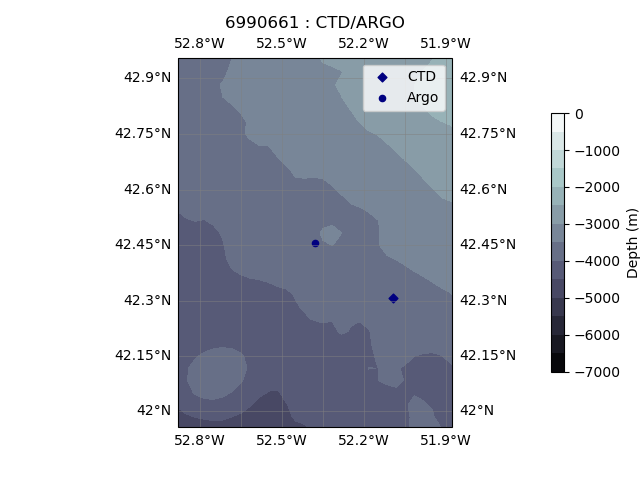

In [38]:
# We estimate a supplement Gain from the CTD without pressure effect.
params_no_corr_pressure = np.array([0])
params_Gain_CTD = np.array([1])
perr_Gain_CTD = np.array([0])
ppox_cruise_tot = np.array([])
doxy_cruise_tot = np.array([])
ppox_cycle_corr_tot = np.array([])
doxy_cycle_corr_tot = np.array([])
pres_corr_tot = np.array([])

# Compare ARGO Profil  with  CTD. We compare OXYGEN directly
if cmp_ctd==1:
    for i_ctd in np.arange(len(num_ctd)):
        _=plot_CTD_Argo_Pos(ds_argo_Sprof, ds_bathy,depths,extend_lon_lat,rep_ctd,fic_ctd,num_ctd,num_cycle)
        plt.savefig(os.path.join(rep_fic_fig,num_float +'_cmp_CTD_argo.png'))

        ds_cruise = xr.open_dataset(rep_ctd[i_ctd] + fic_ctd[i_ctd])
        ds_cruise = ds_cruise.where(ds_cruise['STATION_NUMBER']==num_ctd[i_ctd],drop=True)
        ds_cycle = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']==num_cycle[i_ctd]) & (ds_argo_Sprof['DIRECTION']=='A'),drop=True)

        ana_dens_cruise = sw.pden(ds_cruise['PSAL'],ds_cruise['TEMP'],ds_cruise['PRES'],0)
        O2_cruise_umolL = umolkg_to_umolL(ds_cruise['OXYK'],ds_cycle['DOXY'].units,ana_dens_cruise[0])
        ppox_cruise = O2ctoO2p(O2_cruise_umolL,ds_cruise['TEMP'].isel(N_PROF=0),ds_cruise['PSAL'].isel(N_PROF=0),ds_cruise['PRES'].isel(N_PROF=0)) # On calcule PPOX pour P=0
        ppox_cruise_interp = np.interp(ds_cycle['PRES'],ds_cruise['PRES'].isel(N_PROF=0),ppox_cruise[0])
        doxy_cruise_interp = np.interp(ds_cycle['PRES'],ds_cruise['PRES'].isel(N_PROF=0),ds_cruise['OXYK'].isel(N_PROF=0))
        ppox_cruise_tot = np.concatenate((ppox_cruise_tot,ppox_cruise_interp),axis=None)
        doxy_cruise_tot = np.concatenate((doxy_cruise_tot,doxy_cruise_interp),axis=None)
        
        delta_T_Sprof = diff_time_in_days(ds_cycle['JULD'].values,launch_date)
        tab_delta_T= np.tile(delta_T_Sprof,(1,len(ds_cycle['N_LEVELS'])))

        ana_dens_cycle = sw.pden(ds_cycle['PSAL_ADJUSTED'],ds_cycle['TEMP_ADJUSTED'],ds_cycle['PRES_ADJUSTED'],0)
        O2_cycle_umolL = umolkg_to_umolL(ds_cycle['DOXY'],ds_cycle['DOXY'].units,ana_dens_cycle[0])
        ppox_cycle = O2ctoO2p(O2_cycle_umolL,ds_cycle['TEMP_ADJUSTED'].isel(N_PROF=0),ds_cycle['PSAL_ADJUSTED'].isel(N_PROF=0),ds_cycle['PRES_ADJUSTED'].isel(N_PROF=0)) # On calcule PPOX pour P=0
        if nb_param == 1:
            ppox_cycle_corr = model_Gain(ppox_cycle,*params_to_keep)
            doxy_cycle_corr = model_Gain(ds_cycle['DOXY'],*params_to_keep)
        else:
            ppox_cycle_corr = model_Gain_Derive([ppox_cycle,tab_delta_T],*params_to_keep)
            doxy_cycle_corr = model_Gain_Derive([ds_cycle['DOXY'],tab_delta_T],*params_to_keep)


        ppox_cycle_corr_tot = np.concatenate((ppox_cycle_corr_tot,ppox_cycle_corr),axis=None)
        doxy_cycle_corr_tot = np.concatenate((doxy_cycle_corr_tot,doxy_cycle_corr),axis=None)
        pres_corr_tot = np.concatenate((pres_corr_tot,ds_cycle['PRES'].isel(N_PROF=0).values),axis=None)
 
    
    # Solution without pressure correction
    # CTD Gain estimation
    initial_guess = 0
    params_Gain_CTD_V2, covariance = curve_fit(model_Gain, ppox_cycle_corr_tot, ppox_cruise_tot, p0=initial_guess,nan_policy='omit')
    perr_Gain_CTD_V2 = np.sqrt(np.diag(covariance))

    params_Gain_CTD, covariance = curve_fit(model_Gain, doxy_cycle_corr_tot, doxy_cruise_tot, p0=initial_guess,nan_policy='omit')
    perr_Gain_CTD = np.sqrt(np.diag(covariance))
    
    print(params_Gain_CTD,perr_Gain_CTD)
    print(params_Gain_CTD_V2,perr_Gain_CTD_V2)

    print("Supplement Gain from CTD (without effect pressure) : ",",".join(f"{val:.4f}" for val in params_Gain_CTD))

[1.11346804]


/var/folders/vb/_nx050wx16vc32wc3vf7tkrw000h29/T/ipykernel_12834/4293315316.py:85: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  _=plt.legend([h1,h2,h3,h4],['CTD','ARGO Corr','ARGO Corr Data used','CTD Data used'])


Pressure effect Estimation
CTD pressure effect estimated with pressure effect : 0.053571 with error 0.001184
CTD Gain estimated with pressure effect : 0.990520 with error 0.002575


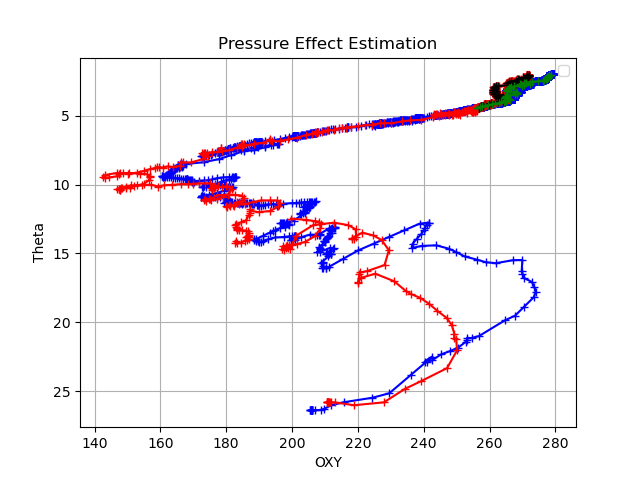

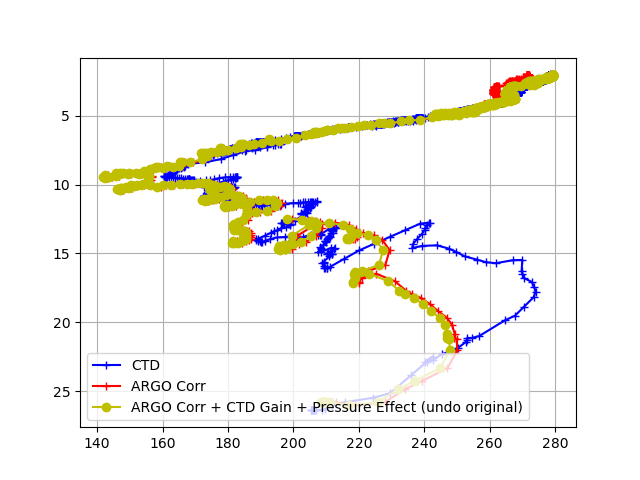

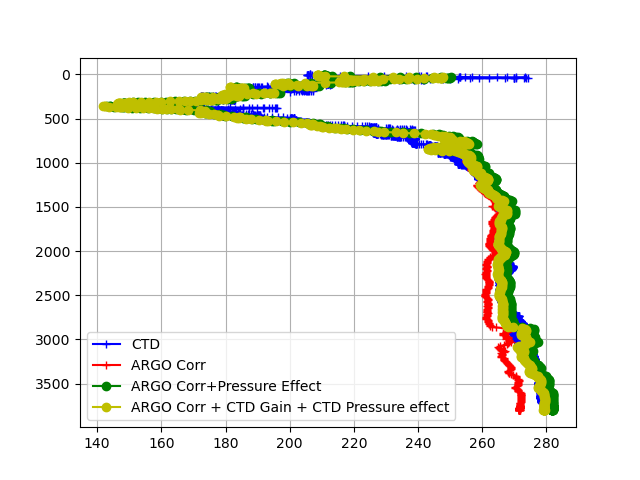

In [39]:
from scipy.interpolate import interp1d

# We estimate a pressure effect by using potentaol temperature.
# Init Pressure correction (0 by default) and a supplement gain from CTD (1 by default)
params_Gain_CTD_with_pressure = np.array([1])
params_corr_pressure = np.array([0])
perr_pressure = np.array([0,0])

print(params_to_keep)
# Pressure effect estimation.
# We compare ARGO O2 with CTD O2.
# According to V. Thierry, we must estimate a Gain and a pressure effect.
# Estimate only a pressure effect seems to be incorrect.
# We do thatfrom the 'first' correction.
strvar = '_ADJUSTED'
if cmp_ctd==1:
    for i_ctd in np.arange(len(num_ctd)):
        ds_cruise = xr.open_dataset(rep_ctd[i_ctd] + fic_ctd[i_ctd])
        ds_cruise = ds_cruise.where(ds_cruise['STATION_NUMBER']==num_ctd[i_ctd],drop=True)
        ds_cycle = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']==num_cycle[i_ctd]) & (ds_argo_Sprof['DIRECTION']=='A'),drop=True)
        delta_T_Sprof = diff_time_in_days(ds_cycle['JULD'].values,launch_date)
        tab_delta_T= np.tile(delta_T_Sprof,(1,len(ds_cycle['N_LEVELS'])))
        
        if nb_param == 1:
            doxy_ARGO_corr = model_Gain(ds_cycle['DOXY'],*params_to_keep)
        else:
            doxy_ARGO_corr = model_Gain_Derive([ds_cycle['DOXY'],tab_delta_T],*params_to_keep)

        # Compute ARGO and CTD theta.
        psal_cycle = ds_cycle['PSAL'+strvar].values
        pres_cycle = ds_cycle['PRES'+strvar].values 
        temp_cycle = ds_cycle['TEMP'+strvar].values
        theta_cycle = sw.ptmp(psal_cycle,temp_cycle,pres_cycle,0)

        psal_cruise = ds_cruise['PSAL'].values
        pres_cruise = ds_cruise['PRES'].values
        temp_cruise = ds_cruise['TEMP'].values
        theta_cruise = sw.ptmp(psal_cruise,temp_cruise,pres_cruise,0)

        plt.figure()
        h1 = plt.plot(ds_cruise['OXYK'][0],theta_cruise[0],'+-b')
        h2 = plt.plot(doxy_ARGO_corr[0],theta_cycle[0],'+-r')

        theta_common = np.linspace(max(np.nanmin(theta_cycle), np.nanmin(theta_cruise)),
                                   min(np.nanmax(theta_cycle), np.nanmax(theta_cruise)),
                                   500)

        valid = ~np.isnan(theta_cycle[0]) & ~np.isnan(doxy_ARGO_corr[0])
        # Defintion fonction interpolation.
        interp_o2_cycle = interp1d(theta_cycle[0][valid], doxy_ARGO_corr[0][valid], bounds_error=False, fill_value=np.nan)
        interp_o2_cruise = interp1d(theta_cruise[0], ds_cruise['OXYK'][0], bounds_error=False, fill_value=np.nan)
        interp_pres_cycle = interp1d(theta_cycle[0], pres_cycle[0], bounds_error=False, fill_value=np.nan)
        interp_temp_cycle = interp1d(theta_cycle[0], temp_cycle[0], bounds_error=False, fill_value=np.nan)

        # Interpolation on theta communs entre CTD and ARGO
        o2_cycle_theta = interp_o2_cycle(theta_common)
        o2_cruise_theta = interp_o2_cruise(theta_common)
        p_cycle_theta = interp_pres_cycle(theta_common)
        temp_cycle_theta = interp_temp_cycle(theta_common)

        # Remove Nan Values
        valid = ~np.isnan(o2_cycle_theta) & ~np.isnan(o2_cruise_theta) & ~np.isnan(p_cycle_theta)
        o2_cycle_theta = o2_cycle_theta[valid]
        o2_cruise_theta = o2_cruise_theta[valid]
        p_cycle_theta = p_cycle_theta[valid]
        temp_cycle_theta = temp_cycle_theta[valid]
        theta_common = theta_common[valid]

        
        PRES_1D = p_cycle_theta.squeeze()  
        mask = PRES_1D >= pressure_threshold
        pres_pour_pres = p_cycle_theta[mask]
        temp_pour_pres = temp_cycle_theta[mask]
        doxy_cruise_pour_pres = o2_cruise_theta[mask]
        doxy_cycle_pour_pres = o2_cycle_theta[mask]


       
        h3=plt.plot(doxy_cycle_pour_pres,theta_common[mask],'+-k')
        h4=plt.plot(doxy_cruise_pour_pres,theta_common[mask],'+-g')
        plt.gca().invert_yaxis()
        plt.grid()
        plt.xlabel('OXY')
        plt.ylabel('Theta')
        _=plt.legend([h1,h2,h3,h4],['CTD','ARGO Corr','ARGO Corr Data used','CTD Data used'])
        plt.title('Pressure Effect Estimation')
        plt.savefig(os.path.join(rep_fic_fig,num_float +'_data_theta_pressure_effect.png'))

        print('Pressure effect Estimation')
        initial_guess = [1,0]   
        #params_corr_pressure, covariance = curve_fit(model_corr_pres, [(cycle_pour_pres*doxy_cruise_mean/doxy_argo_mean)[0].values,pres_pour_pres[0].values], oxy_pour_pres, p0=initial_guess,nan_policy='omit') 
        #params_corr_pressure, covariance = curve_fit(model_Gain_pres, [doxy_cycle_pour_pres,pres_pour_pres], doxy_cruise_pour_pres, p0=initial_guess,nan_policy='omit') 
        params_corr_pressure, covariance = curve_fit(lambda X, G, Gp: model_Gain_pres(X, G, Gp, pcoef2, pcoef3),
                       [doxy_cycle_pour_pres,pres_pour_pres,temp_pour_pres], doxy_cruise_pour_pres, p0=initial_guess,nan_policy='omit')
        perr_pressure = np.sqrt(np.diag(covariance))
        print(f'CTD pressure effect estimated with pressure effect : {params_corr_pressure[1]:.6f} with error {perr_pressure[1]:.6f}')
        print(f'CTD Gain estimated with pressure effect : {params_corr_pressure[0]:.6f} with error {perr_pressure[0]:.6f}')

        plt.figure()
        h1 = plt.plot(ds_cruise['OXYK'][0],theta_cruise[0],'+-b')
        h2 = plt.plot(doxy_ARGO_corr[0],theta_cycle[0],'+-r')
        h3=plt.plot(doxy_ARGO_corr[0]*1/(1+(pcoef2*ds_cycle['TEMP']+pcoef3)*ds_cycle['PRES'][0]/1000)*(1+(pcoef2*ds_cycle['TEMP']+params_corr_pressure[1])*ds_cycle['PRES'][0]/1000)*params_corr_pressure[0],theta_cycle[0],'o-y')        
        plt.gca().invert_yaxis()
        plt.grid()
        _=plt.legend([h1[0],h2[0],h3[0],h4[0]],['CTD','ARGO Corr','ARGO Corr + CTD Gain + Pressure Effect (undo original)'])
        plt.savefig(os.path.join(rep_fic_fig,num_float +'_data_theta_pressure_effect_corr.png'))

        plt.figure()
        h1 = plt.plot(ds_cruise['OXYK'][0],ds_cruise['PRES'][0],'+-b')
        h2 = plt.plot(doxy_ARGO_corr[0],ds_cycle['PRES'][0],'+-r')
        h3=plt.plot(doxy_ARGO_corr[0]*1/(1+(pcoef2*ds_cycle['TEMP']+pcoef3)*ds_cycle['PRES'][0]/1000)*(1+(pcoef2*ds_cycle['TEMP']+ params_corr_pressure[1])*ds_cycle['PRES'][0]/1000),ds_cycle['PRES'][0],'o-g')  
        h4=plt.plot(doxy_ARGO_corr[0]*1/(1+(pcoef2*ds_cycle['TEMP']+pcoef3)*ds_cycle['PRES'][0]/1000)*(1+(pcoef2*ds_cycle['TEMP']+params_corr_pressure[1])*ds_cycle['PRES'][0]/1000)*params_corr_pressure[0],ds_cycle['PRES'][0],'o-y')        
        plt.gca().invert_yaxis()
        plt.grid()
        _=plt.legend([h1[0],h2[0],h3[0], h4[0]],['CTD','ARGO Corr','ARGO Corr+Pressure Effect','ARGO Corr + CTD Gain + CTD Pressure effect'])
        plt.savefig(os.path.join(rep_fic_fig,num_float +'_data_theta_pressure_effet_res.png'))

        params_Gain_CTD_with_pressure = np.array([params_corr_pressure[0]])
        params_corr_pressure = np.array([params_corr_pressure[1]])


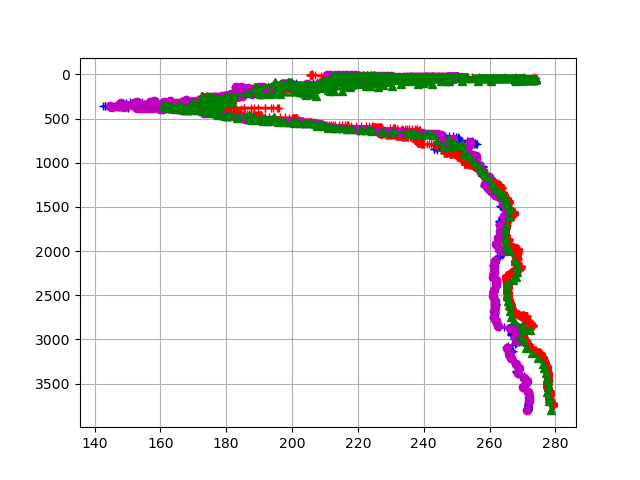

In [40]:
plt.figure()
h1 = plt.plot(doxy_ARGO_corr[0],pres_cycle[0],'+-b')
h2 = plt.plot(ds_cruise['OXYK'][0],ds_cruise['PRES'][0],'+-r')
plt.gca().invert_yaxis()
h3 = plt.plot(o2_cycle_theta,p_cycle_theta,'o-m')
h4 = plt.plot(o2_cruise_theta,p_cycle_theta,'^-g')
plt.grid()

In [41]:
# Compute final correction with or without pressure effect.
print(perr_to_keep)
derive_final = 0
if len(params_to_keep) == 1:
    derive_final = 0
    perr_to_keep = np.append(perr_to_keep, 0) # error on drift
    perr_to_keep = np.append(perr_to_keep, 0) # error on pressure effect
else :
    derive_final = params_to_keep[1]
    perr_to_keep = np.append(perr_to_keep, 0) # error on pressure effect
print(perr_to_keep)

[0.00363353]
[0.00363353 0.         0.        ]


In [42]:
corr_final_without_pressure_correction = np.array([params_to_keep[0],derive_final,params_no_corr_pressure[0]])
corr_final_with_pressure_correction = np.array([params_to_keep[0],derive_final,params_corr_pressure[0]])
corr_final_CTD_without_pressure_correction = np.array([params_Gain_CTD[0] * params_to_keep[0],derive_final,params_no_corr_pressure[0]])
corr_final_CTD_with_pressure_correction = np.array([params_Gain_CTD_with_pressure[0] * params_to_keep[0],derive_final,params_corr_pressure[0]])
perr_final = perr_to_keep # correction to keep
perr_final_pressure = [perr_to_keep[0] ,perr_to_keep[1],perr_pressure[1]] # correction to keep with pressure effect
#perr_final_CTD = [perr_to_keep[0] + perr_Gain_CTD[0],perr_to_keep[1],perr_to_keep[2]] # correction to keep with CTD supplement Gain
#perr_final_CTD_with_pressure = [perr_to_keep[0] + perr_pressure[0],perr_to_keep[1],perr_pressure[1]] # correction to keep with CTD effect pressure and CTD Gain
perr_final_CTD = [np.sqrt(perr_to_keep[0]*perr_to_keep[0] + perr_Gain_CTD[0]*perr_Gain_CTD[0]),perr_to_keep[1],perr_to_keep[2]] # correction to keep with CTD supplement Gain
perr_final_CTD_with_pressure = [np.sqrt(perr_to_keep[0]*perr_to_keep[0] + perr_pressure[0]*perr_pressure[0]),perr_to_keep[1],perr_pressure[1]] # correction to keep with CTD effect pressure and CTD Gain

print("Initial Correction without pressure effect (Gain/Drift/Pressure effect) : ","/".join(f"{val:.4f}" for val in corr_final_without_pressure_correction) + " with error : ","/".join(f"{val:.4f}" for val in perr_final))
print("Initial Correction with pressure effect (Gain/Drift/Pressure effect) : ","/".join(f"{val:.4f}" for val in corr_final_with_pressure_correction) + " with error : ","/".join(f"{val:.4f}" for val in perr_final_pressure))
print("Initiale Correction + CTD Correction without pressure effect (Gain/Drift/Pressure effect) : ","/".join(f"{val:.4f}" for val in corr_final_CTD_without_pressure_correction) + " with error : ","/".join(f"{val:.4f}" for val in perr_final_CTD))
print("Initial Correction with pressure effect + CTD Correction  (Gain/Drift/Pressure effect) : ","/".join(f"{val:.4f}" for val in corr_final_CTD_with_pressure_correction) + " with error : ","/".join(f"{val:.4f}" for val in perr_final_CTD_with_pressure))

Initial Correction without pressure effect (Gain/Drift/Pressure effect) :  1.1135/0.0000/0.0000 with error :  0.0036/0.0000/0.0000
Initial Correction with pressure effect (Gain/Drift/Pressure effect) :  1.1135/0.0000/0.0536 with error :  0.0036/0.0000/0.0012
Initiale Correction + CTD Correction without pressure effect (Gain/Drift/Pressure effect) :  1.1313/0.0000/0.0000 with error :  0.0039/0.0000/0.0000
Initial Correction with pressure effect + CTD Correction  (Gain/Drift/Pressure effect) :  1.1029/0.0000/0.0536 with error :  0.0045/0.0000/0.0012


In [43]:
print(type(pcoef2))

<class 'float'>


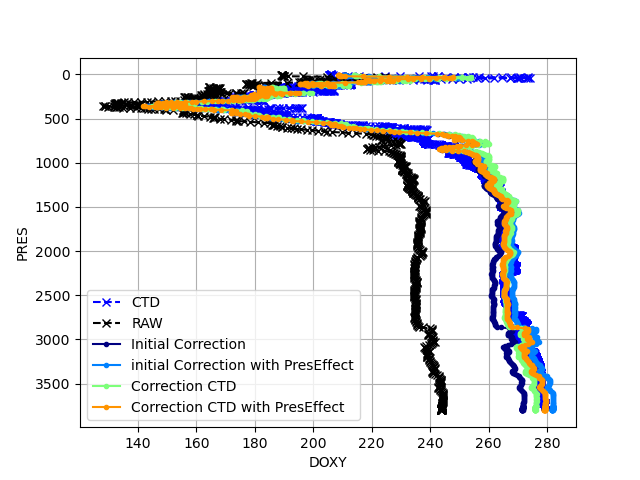

In [44]:
if cmp_ctd==1:
    for i_ctd in np.arange(len(num_ctd)):
        ds_cruise = xr.open_dataset(rep_ctd[i_ctd] + fic_ctd[i_ctd])
        ds_cruise = ds_cruise.where(ds_cruise['STATION_NUMBER']==num_ctd[i_ctd],drop=True)
        ds_cycle = ds_argo_Sprof.where((ds_argo_Sprof['CYCLE_NUMBER']==num_cycle[i_ctd]) & (ds_argo_Sprof['DIRECTION']=='A'),drop=True)
        dict_corr = {'Initial Correction' : corr_final_without_pressure_correction,'initial Correction with PresEffect' : corr_final_with_pressure_correction,'Correction CTD' : corr_final_CTD_without_pressure_correction,
                     'Correction CTD with PresEffect' : corr_final_CTD_with_pressure_correction}
        
        _=plot_cmp_ARGO_CTD(ds_cruise,ds_cycle,dict_corr,launch_date,pcoef2,pcoef3) 
        plt.savefig(os.path.join(rep_fic_fig,num_float +'_cmp_differents_corr_with_CTD.png'))

        

In [45]:
#
# Which correction to apply (without or with pressure correction).
#
corr_to_apply  = 4
if corr_to_apply == 1:
    corr_final_to_use = corr_final_without_pressure_correction
    perr_to_use = perr_final
elif corr_to_apply == 2 :
    corr_final_to_use = corr_final_with_pressure_correction
    comment_corr = comment_corr + ' and a pressure effect'
    perr_to_use = perr_final_pressure
elif corr_to_apply == 3:
    corr_final_to_use = corr_final_CTD_without_pressure_correction
    coment_corr = comment_corr + ' and CTD Gain'
    perr_to_use = perr_final_CTD

else:
    corr_final_to_use = corr_final_CTD_with_pressure_correction
    comment_corr = comment_corr + ' and CTD Gain and pressure effect'
    perr_to_use = perr_final_CTD_with_pressure


print(comment_corr)
print("/".join(f"{val:.4f}" for val in corr_final_to_use))
print(perr_to_use)

Correction with a NCEP Gain and CTD Gain and pressure effect
1.1029/0.0000/0.0536
[0.004453616073954261, 0.0, 0.0011837927830243985]


In [46]:
# Écriture dans un fichier ASCII
liste_comment = ["Slope from WOA : ","Slope/Drift from WOA :",
                 "Slope from NCEP","Slope from NCEP CarryOver", 
                 "Slope/Drift with NCEP","Slope/Drift with NCEP CarryOver", 
                 "Correction kept from the 6 above (Slope/Drift/Pressure Effect)",
                 "Correction kept with pressure effect (Slope/Drift/Pressure Effect)",
                 "Correction kept with CTD  (Slope/Drift/Pressure Effect)",
                 "Correction kept with CTD and pressure Effect (Slope/Drift/Pressure Effect)",
                 "\nCorrection to use : ",
                 comment_corr
                ]
liste_corr = [params_Gain_WOA,params_Gain_Derive_WOA,
              params_Gain_NCEP,params_Gain_NCEP_CarryOver,
              params_Gain_Derive_NCEP,params_Gain_Derive_NCEP_CarryOver,
              corr_final_without_pressure_correction, corr_final_with_pressure_correction,
              corr_final_CTD_without_pressure_correction,corr_final_CTD_with_pressure_correction,
              [],
              corr_final_to_use]

liste_error = [perr_Gain_WOA,perr_Gain_Derive_WOA,
              perr_Gain_NCEP,perr_Gain_NCEP_CarryOver,
              perr_Gain_Derive_NCEP,perr_Gain_Derive_NCEP_CarryOver,
              perr_final,perr_final_pressure,
              perr_final_CTD,perr_final_CTD_with_pressure,
              [],
              perr_to_use]

write_ASCII_file(fic_res_ASCII,num_float,liste_comment,liste_corr,liste_error)              
 

Final Correction
Number of pieces : 1
[1.10291184 0.         0.05357083]
Final Correction
Number of pieces : 1
[1.10291184 0.         0.05357083]


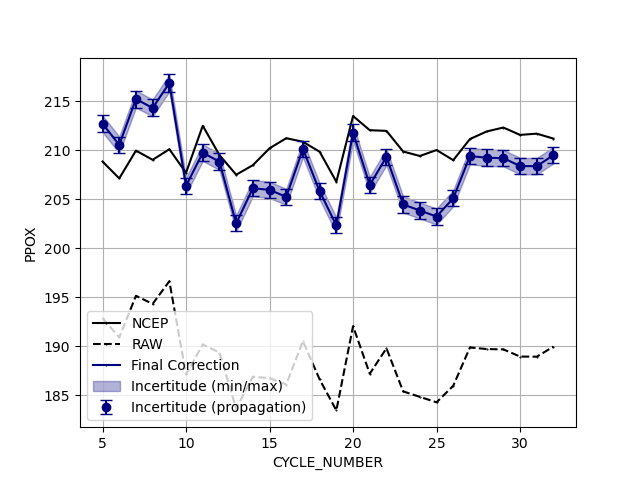

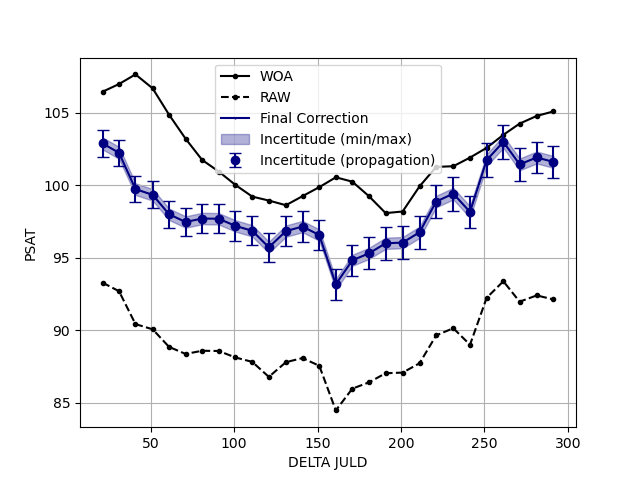

In [47]:
# Comparaison correction finale avec NCEP ET PSAT WOA
dict_corr = {'Final Correction' : corr_final_to_use}
deltaT_list=[[]] * len(dict_corr)
tab_error = np.array(perr_to_use)
_=plot_cmp_corr_NCEP_with_error(dict_corr,np.tile(tab_error, (len(dict_corr), 1)),deltaT_list,dsair,NCEP_PPOX,delta_T_NCEP)
plt.savefig(os.path.join(rep_fic_fig,num_float +'_cmp_NCEP_final_corr.png'))
_=plot_cmp_corr_WOA_with_error(dict_corr,np.tile(tab_error, (len(dict_corr), 1)),deltaT_list,ds_argo_interp, ds_woa_interp, delta_T_WOA)
plt.savefig(os.path.join(rep_fic_fig,num_float +'_cmp_PSATWOA_final_corr.png'))

In [48]:
# BR/BD files correction
val_bid = os.path.join(rep_data_argo,num_float,'profiles','B?' +num_float + '_???.nc')
fic_argo = glob.glob(val_bid)
fic_argo.sort()

for i_fic in range(0,len(fic_argo)):
    fic_en_cours = fic_argo[i_fic]
    fic_res = os.path.join(rep_fic_res,os.path.basename(fic_en_cours))
    fic_res = fic_res.replace('BR','BD',1)
    ds = xr.open_dataset(fic_en_cours,engine='argo')
    cycle_en_cours = ds['CYCLE_NUMBER'].values[0]
    juld_en_cours = ds['JULD'].values[0]
    delta_T_en_cours = diff_time_in_days(juld_en_cours,launch_date)
    if (cycle_en_cours >= first_cycle_to_use) & (cycle_en_cours<=last_cycle_to_use):
        coef_pres = corr_final_to_use[2]
        gain_final = corr_final_to_use[0]
        derive_final = corr_final_to_use[1]  
        coef_corr = f'INCLINE_T=0, SLOPE={gain_final}, DRIFT={derive_final}, COEF_PRES ={coef_pres},OFFSET=0.000000'
        eq_corr = 'DOXY2 = DOXY / (1 + (Pcoef2*TEMP + coef3)*PRES/1000) * (1 + (Pcoef2*TEMP + coef_pres)*PRES/1000),DOXY_ADJUSTED=OFFSET+(SLOPE*(1+DRIFT/100.*(profile_date_juld-launch_date_juld)/365)+INCLINE_T*TEMP)*DOXY2'
        print(f'Correction de {fic_en_cours} avec {corr_final_to_use}')
        if os.path.exists(fic_res):
            os.remove(fic_res)
        corr_file(fic_en_cours,fic_res,launch_date,comment_corr,coef_corr,eq_corr,pcoef2,pcoef3,gain_final,derive_final,coef_pres,percent_relative_error)

Correction de /Users/chemon/ARGO_NEW/rinko_aanderaa/cmp_rinko_aanderaa/doxy_aanderaa/6990661/profiles/BR6990661_005.nc avec [1.10291184 0.         0.05357083]
Lecture de la temperature du fichier /Users/chemon/ARGO_NEW/rinko_aanderaa/cmp_rinko_aanderaa/doxy_aanderaa/6990661/profiles/R6990661_005.nc pour correction de l'effet de pression

Correction de /Users/chemon/ARGO_NEW/rinko_aanderaa/cmp_rinko_aanderaa/doxy_aanderaa/6990661/profiles/BR6990661_006.nc avec [1.10291184 0.         0.05357083]
Lecture de la temperature du fichier /Users/chemon/ARGO_NEW/rinko_aanderaa/cmp_rinko_aanderaa/doxy_aanderaa/6990661/profiles/R6990661_006.nc pour correction de l'effet de pression

Lecture de la temperature du fichier /Users/chemon/ARGO_NEW/rinko_aanderaa/cmp_rinko_aanderaa/doxy_aanderaa/6990661/profiles/R6990661_006.nc pour correction de l'effet de pression

Correction de /Users/chemon/ARGO_NEW/rinko_aanderaa/cmp_rinko_aanderaa/doxy_aanderaa/6990661/profiles/BR6990661_007.nc avec [1.10291184 0. 